# Recurrent Neural Network Parameter Exploration
using multiple full flights to train


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage.filters import uniform_filter1d
import time
%matplotlib inline
#from IPython.display import display, clear_output

import LSTM as ml
import nasa_data_funcs_v4 as ndf  #v4 removes the VRTG, LONG, LATG

/tmp/ipykernel_1260086/520271836.py:9: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


In [3]:
#setting the cuda device

use_cpu = True

if torch.cuda.is_available() and not use_cpu:
    cuda0 = torch.device('cuda:0')
    cuda1 = torch.device('cuda:1')
    cuda2 = torch.device('cuda:2')
    cuda3 = torch.device('cuda:3')
    device = cuda2
else:
    device = torch.device('cpu')

#torch.cuda.set_device(device)a
device

device(type='cpu')

In [5]:
#loading the pre-trained model

#this model is from the regular methodology and matches the average MSE of the papers analysis of this methodology
# model_name = 'Tail_687_1_parquet/RecurrentNeuralNetwork_rand-multiflight_loop_noVRTG_batch_newParamsBest9.pt'

#best model of the whole experiment!!
model_name = 'Tail_687_1_parquet/RecurrentNeuralNetwork_rand-multiflight_loop_noVRTG_batch_newParams2-3_update_config4_bootloop2_best.pt'

#this mode is the last file saved from the regular methodology and has the average MSE in the model card
#  5.281388949166891e-05
#model_name = 'RecurrentNeuralNetwork_rand-multiflight_loop_noVRTG_batch_newParamsBest_w-avgMSE.pt'

#this model has the average MSE over the whole bootstrap loop
#model_name = 'RecurrentNeuralNetwork_rand-multiflight_loop_noVRTG_batch_newParamsBest_randfiles.pt'

#this model has close to the actual MSE that was average for the end of the methodology
#model_name = 'RecurrentNeuralNetwork_rand-multiflight_loop_noVRTG_batch_newParamsBest_randfiles6.pt'

#model = torch.load(model_name, map_location=device)
model = torch.load(model_name, map_location=device)
model.to(device) #sending full model to the correct device
model.device = device #setting the internal "device" variable to the right device when running LSTM forward

cwd = os.getcwd()

#this directory is currently hard-coded in (I know, Not great), so that means this python
# jupyter notebook needs to be run in the same directory as the data
fdir = 'Tail_687_1_parquet'

#custom built __repr__ function in LSTM to spit out data I wanted
model.eval()

/home/boothtm/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


LSTM(Base+removeVar, 23, 1, 16, 0.0007, 20, 1 )

In [8]:
print(f'{model.test_mse=}')
print(f'{model.bootloop_avg_test_mse=}')
print(f'{model.device=}')
print(f'{model.hidden_units=}')
print(f'{model.seq_length=}')
print(f'{model.learning_rate=}')
print(f'{model.approach=}')
print(f'{model.n_epochs=}')
print(f'{model.unit_processing=}')
print(f'{model.model_size=}')
print(f'{model.scaleT=}')
print(f'{model.device=}')
#print(f'{model.model_size_wcard=}')

model.test_mse=1.0885067922572489e-06
model.bootloop_avg_test_mse=2.933555492745654e-06
model.device=device(type='cpu')
model.hidden_units=20
model.seq_length=16
model.learning_rate=0.0007
model.approach='Base+removeVar'
model.n_epochs=3500
model.unit_processing=1.796907268230907e-09
model.model_size=15872
model.scaleT=MinMaxScaler()
model.device=device(type='cpu')


## Scaling MSE to real units of feet


In [9]:
# real_mse = model.scaleT.inverse_transform(np.array([model.test_mse]).reshape(-1,1))[0,0] #inverse transform expects 2D array

print(f'The scaled MSE: {model.test_mse}\n')
# print(f'The real MSE in units of Feet: {real_mse}')

The scaled MSE: 1.0885067922572489e-06



## Plotting testing results from the model

In [10]:
model.test_files

['687200107241524.parquet',
 '687200104301119.parquet',
 '687200104261527.parquet',
 '687200104181334.parquet',
 '687200107301239.parquet',
 '687200104170717.parquet',
 '687200107170234.parquet']

## Setting up the Data and NN configs


In [18]:

def file_list_gen(n_files, cwd, fdir, debug=False, rand=False):

    #debug=debug  #set this up so i can run a smaller set when debugging

    #rand=rand #random set of files from the fdir vs fixed set of files.

    #choose to look at random files in the directory or a set number
    # the set list is for comparing different methods for now.
    
    

    if rand:
        os.chdir(os.path.join(cwd,fdir))
        fulllist = glob.glob(f'*.parquet')
        os.chdir(cwd)
        
        print(len(fulllist))

    else:
        #created this option since there were some "bad" files that were throwing off good
        # analysis.  plus this is easier to see and ensure I don't get duplicate files

        fulllist    =  ["687200107192334.parquet", 
                        "687200107301239.parquet",
                        "687200104261527.parquet",
                        "687200107251002.parquet",
                        "687200104301119.parquet",
                        "687200107101600.parquet",
                        "687200104170717.parquet",
                        "687200107181544.parquet",
                        "687200104202027.parquet",
                        "687200107170234.parquet",
                        "687200107251652.parquet",
                        "687200107122323.parquet",
                        "687200104162039.parquet",
                        "687200107311025.parquet",
                        "687200104181334.parquet",
                        "687200107171131.parquet",
                        "687200104181127.parquet",
                        "687200107241524.parquet",
                        "687200107060930.parquet",
                        "687200107150546.parquet"]


    np.random.shuffle(fulllist)
    #randomize the starting and run through all files eventually

    file_list = fulllist[:n_files]
    
    return file_list





In [23]:



#running through random loops to get an average MSE

def loop_avg(loop_list_length, file_list, seq_length, model, cwd, fdir, just_test=False, ntest=np.nan):

    
    if just_test:
        #this option only runs the files for test and doesn't partition them
        #shuffle the files around in this list to get different results for the bootstrapping
        np.random.shuffle(file_list) 
        test_files = file_list[:ntest]
        train_files = np.nan
    else:
        #this option splits file_list into different partitions
        
        #split training and testing into 2/3 
        ntrain = int((2/3)*n_files)
        ntest = n_files-ntrain

        # #not the best to put into a function call
        # cwd = os.getcwd()

        #shuffle the files around in this list to get different results for the bootstrapping
        np.random.shuffle(file_list)    
        train_files = file_list[:ntrain]
        test_files  = file_list[ntrain:ntrain+ntest]
    
    avg_error_test_list = []

    #find out how many random loops are needed to remain stable
    for n_rand_loops in range(loop_list_length):

        avg_error_test=0
        #bootstrap loop
        n = n_rand_loops +1
        print(n)

        for rf in range(n):

            #shuffle the files around in this list to get different results for the bootstrapping
            np.random.shuffle(file_list)    
            if just_test:
                test_files = file_list[:ntest]
                train_files = np.nan
            else:
                train_files = file_list[:ntrain]
                test_files  = file_list[ntrain:ntrain+ntest]

            #if scaleX is defined in the model use it, otherwise calculate from input training files
            if model.scaleX:
                scaleX = model.scaleX
                scaleT = model.scaleT
            else:
                #load in the training files to get the scale factors
                Xtraindf, Ttraindf, Timetrain, scaleX, scaleT = \
                    ndf.read_parquet_flight_merge(cwd, fdir, train_files, seq_length,\
                                                  scaleX=None, scaleT=None)
                del Xtraindf, Ttraindf

            #load the training files and scale by the scale factors above
            Xtestdf, Ttestdf, Timetest, scaleX, scaleT = \
                ndf.read_parquet_flight_merge(cwd, fdir, test_files, seq_length,\
                                              scaleX=scaleX, scaleT=scaleT)


            #create tensors from the data frames
            Xtest = torch.from_numpy(Xtestdf.astype(np.float32)).to(device)
            Ttest = torch.from_numpy(Ttestdf.astype(np.float32)).to(device)

            #Run the test data through the trained model
            test_output = model(Xtest)

            #Define the loss function used to calculate the difference between the model output and the training Target
            loss_func = torch.nn.MSELoss()

            #calculate the loss of the model output (Y) to the training Target (Ttrain)
            loss = loss_func(test_output, Ttest).detach().cpu()  

            # print(f'error = {loss.item()}')

            avg_error_test += loss.item()

        avg_error_test = avg_error_test/n
        avg_error_test_list.append(avg_error_test)
    
    #clear GPU memory
    del loss, Xtest, Ttest, test_output
    torch.cuda.empty_cache()
    
    return avg_error_test_list



In [51]:
loop_list_length = 20
n_files = 20

file_list = file_list_gen(n_files, cwd, fdir)

avg_error_test_list20 = loop_avg(loop_list_length, file_list, model.seq_length, model, cwd, fdir)



In [53]:
print(f'List of MSE: {avg_error_test_list20}')
len(avg_error_test_list20)

List of MSE: [1.102694341170718e-06, 1.01329595736388e-06, 9.73990495367616e-07, 1.2146755921094154e-06, 1.1857300023621065e-06, 1.2738041353562342e-06, 1.0963416262451834e-06, 1.1843280489642893e-06, 9.906782325843878e-07, 1.0196653079219687e-06, 1.0988746830455718e-06, 1.064277976562759e-06, 1.0038155813582796e-06, 9.972311220605791e-07, 1.1734073950719903e-06, 1.0249457087496694e-06, 1.034130615179867e-06, 1.1323118371819874e-06, 1.0112975432045795e-06, 9.624352685477789e-07]


20

8.779423441327578e-08

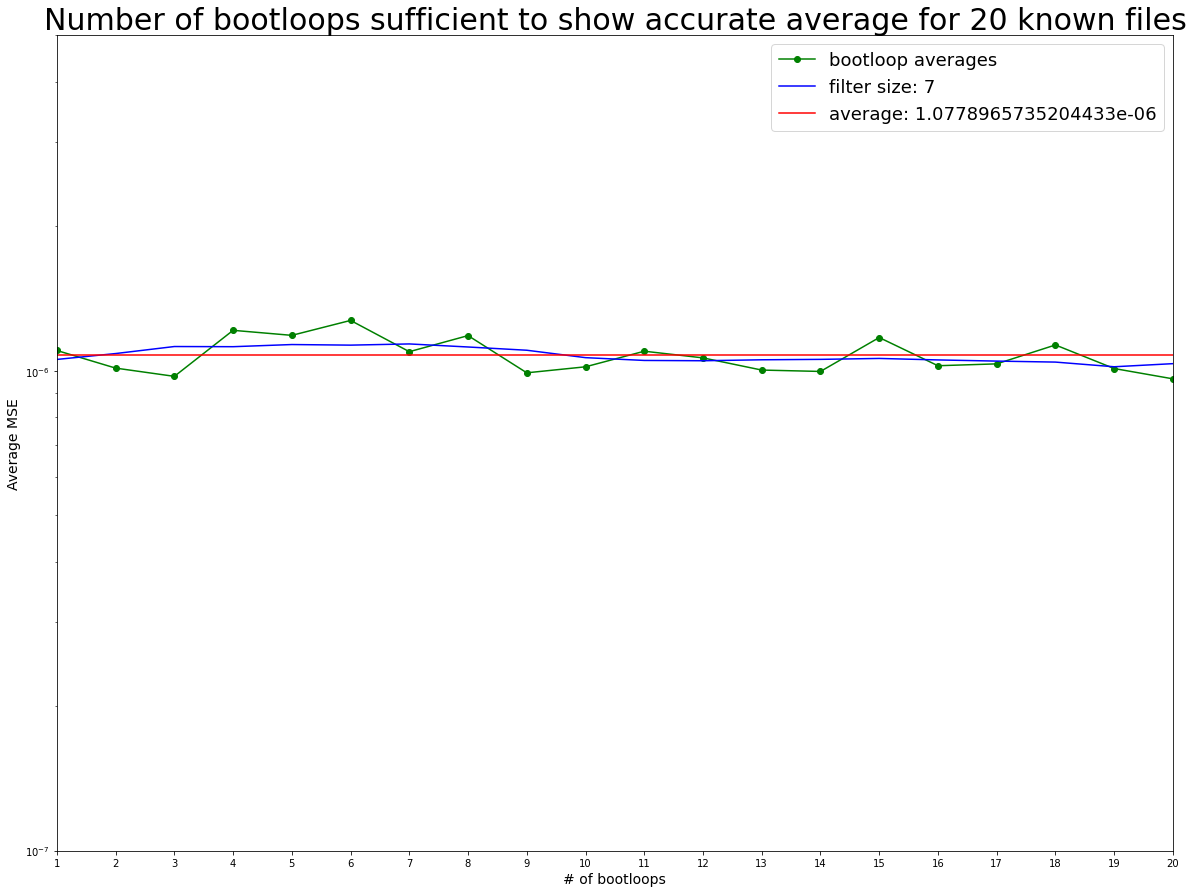

In [54]:
fig = plt.figure(figsize=(20, 15))

n_files = 20
loop_length = np.linspace(1,loop_list_length,loop_list_length)

filter_size = 7
mse_filtered = uniform_filter1d(avg_error_test_list20, size=filter_size)

avg_filter20 = np.mean(mse_filtered)

plt.plot(loop_length, avg_error_test_list20, 'g-o', label='bootloop averages')
plt.plot(loop_length, mse_filtered, 'b-', label=f'filter size: {filter_size}')
plt.plot([1, len(loop_length)], [avg_filter20, avg_filter20], 'r-', label=f'average: {avg_filter20}')

ax = plt.gca()
ax.set_title(f'Number of bootloops sufficient to show accurate average for {n_files} known files',
             fontsize=30)
plt.xlabel('# of bootloops',fontsize=14)
plt.xticks(ticks=loop_length);
plt.xlim(1,len(loop_length))
plt.yscale('log')
plt.ylabel('Average MSE',fontsize=14);
plt.ylim(0.0000001,0.000005);
plt.legend(fontsize=18);

np.array(avg_error_test_list20).std()

Appears that 5-6 bootloops are sufficient with 20 files for this data set

In [90]:
avg_error20 = np.mean(avg_error_test_list20)

avg_error_test_list20[2] - avg_error20

-1.0390607815282719e-07

In [24]:
loop_list_length = 20
n_files = 20

file_list = file_list_gen(n_files, cwd, fdir, rand=False)

#this is using the option in the loop_avg to only use the n_files and file_list for the test averaging.  this way
# we can test a larger average on the same files used for the experiment.
ntest = 14

avg_error_test_list40 = loop_avg(loop_list_length, file_list, model.seq_length, model, cwd, fdir, just_test=True, ntest=ntest)



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [25]:
print(f'List of MSE: {avg_error_test_list40}')

List of MSE: [9.980689128497033e-07, 1.128279791373643e-06, 8.941785457257841e-07, 1.3022581697441638e-06, 9.775956186786061e-07, 1.122165211124108e-06, 1.101549985703189e-06, 1.1057394218028094e-06, 1.1014696118157492e-06, 1.0983729964664236e-06, 1.104595598504106e-06, 1.1314467656120542e-06, 1.1028542329628321e-06, 1.106012843722835e-06, 1.09347824187959e-06, 1.1170375948665878e-06, 1.0985066697845896e-06, 1.1415917021572063e-06, 1.1555802494082233e-06, 1.1443936898558604e-06]


7.685125754530821e-08

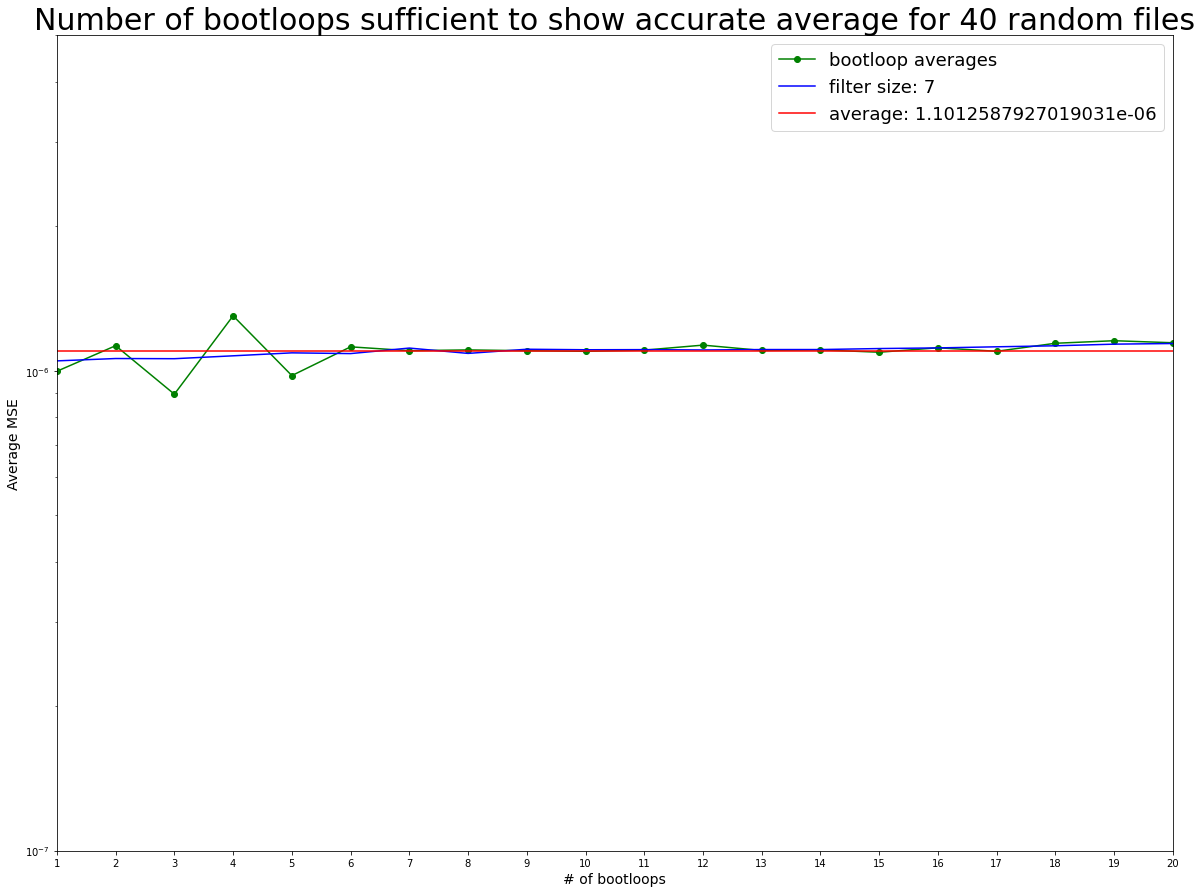

In [31]:
fig = plt.figure(figsize=(20, 15))
n_files = 40
loop_length = np.linspace(1,loop_list_length,loop_list_length)

filter_size = 7
mse_filtered40 = uniform_filter1d(avg_error_test_list40, size=filter_size)

avg_filter40 = np.mean(mse_filtered40)

plt.plot(loop_length, avg_error_test_list40, 'g-o', label='bootloop averages')
plt.plot(loop_length, mse_filtered40, 'b-', label=f'filter size: {filter_size}')
plt.plot([1, len(loop_length)], [avg_filter40, avg_filter40], 'r-', label=f'average: {avg_filter40}')

ax = plt.gca()
ax.set_title(f'Number of bootloops sufficient to show accurate average for {n_files} random files',
             fontsize=30)
plt.xlabel('# of bootloops',fontsize=14)
plt.xticks(ticks=loop_length);
plt.xlim(1,len(loop_length))
plt.ylabel('Average MSE',fontsize=14);
plt.ylim(0.0000001,0.000005);
plt.yscale('log')
plt.legend(fontsize=18);
np.array(avg_error_test_list40).std()

In [33]:
avg_error40 = np.mean(avg_error_test_list40)

avg_error20 - avg_error40

-2.345879270190305e-08

In [3]:
len(file_list)

NameError: name 'file_list' is not defined

It appears that it takes approximately 6 to 7 bootstrap loops, regardless of the number of 
flight files used, on this data set to produce results that are "consistent"

In [119]:
loop_list_length = 15
n_files = 10

file_list = file_list_gen(n_files, cwd, fdir, rand=True)

avg_error_test_list10 = loop_avg(loop_list_length, file_list, seq_length, model, cwd, fdir)



In [120]:
avg_error_test_list10

[0.00022412094403989613,
 9.331733508588513e-05,
 0.00011160708769845466,
 9.1669082394219e-05,
 0.0001416500068444293,
 0.00015844235410137722,
 0.0001683133102363042,
 0.00011857447293550649,
 0.00019003265656970648,
 0.00014205081015461474,
 0.0001419523078683679,
 0.00010014617373599322,
 0.00010973619478486049,
 0.00012751310064881442,
 0.00010922929322987329]

2.3823388985177133e-05

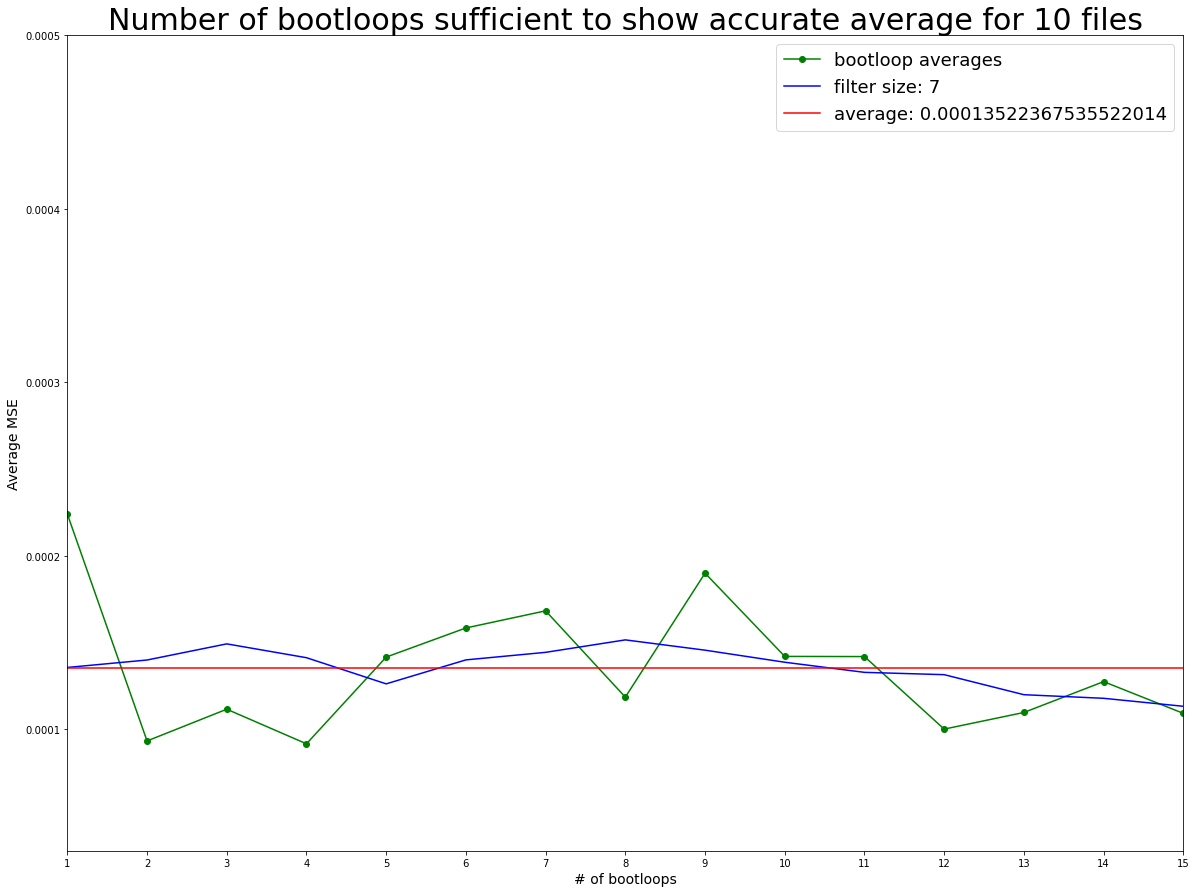

In [233]:
fig = plt.figure(figsize=(20, 15))
n_files = 10
loop_length = np.linspace(1,loop_list_length,loop_list_length)


filter_size = 7
mse_filtered10 = uniform_filter1d(avg_error_test_list10, size=filter_size)

avg_filter10 = np.mean(mse_filtered10)

plt.plot(loop_length, avg_error_test_list10, 'g-o', label='bootloop averages')
plt.plot(loop_length, mse_filtered10, 'b-', label=f'filter size: {filter_size}')
plt.plot([1, len(loop_length)], [avg_filter10, avg_filter10], 'r-', label=f'average: {avg_filter10}')

ax = plt.gca()
ax.set_title(f'Number of bootloops sufficient to show accurate average for {n_files} random files',
             fontsize=30)
plt.xlabel('# of bootloops',fontsize=14)
plt.xticks(ticks=loop_length);
plt.xlim(1,len(loop_length))
plt.ylabel('Average MSE',fontsize=14);
plt.ylim(0.00003,0.0005);
plt.legend(fontsize=18);
np.array(avg_error_test_list20).std()

It appears that it takes about 6-7 for 10 files, but it is less consistent than with 20 files from the same list

# Verification of inputs for each model approach


In [38]:
os.getcwd()

'/s/chopin/b/grad/boothtm/research/nasa'

In [41]:
fdir = 'Tail_687_1_parquet'
model_name = 'RecurrentNeuralNetwork_rand-multiflight_loop_noVRTG_batch_newParams2-3_update_config4_bootloop2_best.pt'
model_name = 'RecurrentNeuralNetwork_rand-multiflight_loop_noVRTG_batch_elevation_newParams2-3_update_config9_bootloop2_best.pt'
model_name = 'RecurrentNeuralNetwork_rand-multiflight_loop_baseline_batch_newParams2-3_update_config5_bootloop0_best.pt'
model_name = 'RecurrentNeuralNetwork_rand-multiflight_loop_batch_airborne_IsoFrstFilter_elevation_newParams2.pt'
model_name = 'RecurrentNeuralNetwork_rand-multiflight_loop_batch_airborne_newParams2-3_update_config6_bootloop2_best.pt'

model = torch.load(os.path.join(fdir,model_name))
model.to(device) #sending full model to the correct device
model.device = device #setting the internal "device" variable to the right device when running LSTM forward

#custom built __repr__ function in LSTM to spit out data I wanted
model.eval()

LSTM(Base+removeVar, 26, 1, 4, 0.0007, 25, 1 )

# convert errors back to real units

In [215]:
n_files = 20

file_list = file_list_gen(n_files, cwd, fdir)


#split training and testing into 2/3 
ntrain = int((2/3)*n_files)
ntest = n_files-ntrain

train_files = file_list[:ntrain]
test_files  = file_list[ntrain:ntrain+ntest]

#load in the training files to get the scale factors
Xtraindf, Ttraindf, Timetrain, scaleX, scaleT = \
    ndf.read_parquet_flight_merge(cwd, fdir, train_files, seq_length, scaleX=None, \
                                  scaleT=None, VRTG=True)

#delete these variables you don't need them
#del Xtraindf, Ttraindf

#load the training files and scale by the scale factors above
Xtestdf, Ttestdf, Timetest, scaleX, scaleT = \
    ndf.read_parquet_flight_merge(cwd, fdir, test_files, seq_length, scaleX=scaleX, \
                                  scaleT=scaleT, VRTG=True)


#create tensors from the data frames
Xtest = torch.from_numpy(Xtestdf.astype(np.float32)).to(device)
Ttest = torch.from_numpy(Ttestdf.astype(np.float32)).to(device)

test_output = model(Xtest)

#Define the loss function used to calculate the difference between the model output and the training Target
loss_func = torch.nn.MSELoss()

#calculate the loss of the model output (Y) to the training Target (Ttrain)
loss = loss_func(test_output, Ttest).detach().cpu()  

In [216]:
scaled_mse

6.759025382052641e-06

In [217]:
#Run the test data through the trained model
#rate of data
frequency = 16

start_time = time.time()
test_output = model(Xtest)
total_time = time.time() - start_time
total_points = np.size(Xtestdf)
print(f'model usage took: {total_time} secs for {total_points} points')


#processing time per 1 second of real time
unit_processing = total_time/(total_points/frequency)

print(f'unit processing: {unit_processing}')

#

print(f'Mean Squared Error for this dataset: {scaled_mse}\n')
print(f'Files in testing dataset:\n{test_files}')

model usage took: 0.12215852737426758 secs for 112263424 points
unit processing: 1.7410269243064252e-08
Mean Squared Error for this dataset: 6.759025382052641e-06

Files in testing dataset:
['687200104261527.parquet', '687200107301239.parquet', '687200104181127.parquet', '687200107181544.parquet', '687200104202027.parquet', '687200104170717.parquet', '687200107122323.parquet']


In [218]:
print(f'MSE above should be comparable to the average MSE calculated with 20 files: {avg_filter20}')

MSE above should be comparable to the average MSE calculated with 20 files: 7.478921749589305e-05


In [219]:
#removing the scaling factor to plot in real units
Ttest_alt = scaleT.inverse_transform(Ttestdf) #target altitude
Ytest_alt = scaleT.inverse_transform(test_output.detach().cpu().numpy()) #model altitude

NameError: name 'Timetest' is not defined

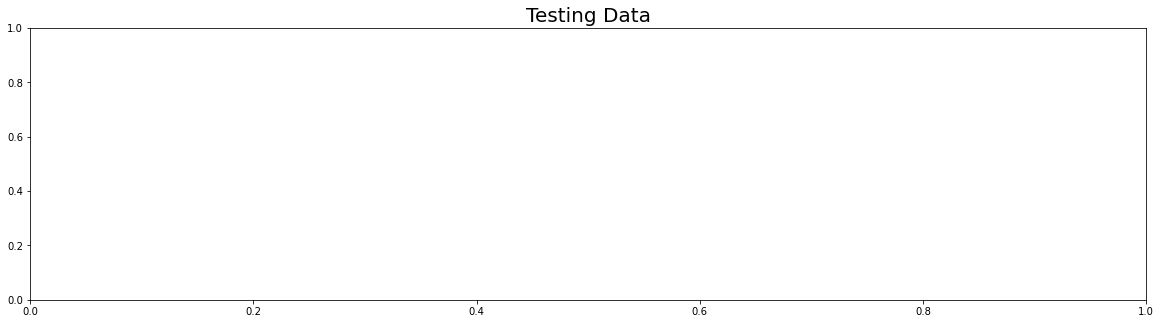

In [20]:
fig = plt.figure(figsize=(20, 5))
#fig.suptitle('Model vs Test Data',fontsize=20)

#number of vertical subplots
nv = 2

#subplot 1
#ax1 = plt.subplot(nv,1,1)
ax1 = plt.gca()
ax1.set_title('Testing Data', fontsize=20)
plt.plot(Timetest, Ttest_alt, 'ro', label='Target Altitude')
plt.plot(Timetest, Ytest_alt, 'b.', label='Model Altitude')
plt.legend(fontsize=14)
plt.ylabel('Altitude (ft) ',fontsize=14)

fig = plt.figure(figsize=(20,10))
#subplot 2
istart = 42500
istop  = 42600

#ax2 = plt.subplot(nv,1,2)
ax2 = plt.gca()
ax2.set_title('Testing Data (Zoomed In)', fontsize=20)
plt.plot(Timetest[istart:istop], Ttest_alt[istart:istop], 'ro', label='Target Altitude (4 Hz)')
plt.plot(Timetest[istart:istop], Ytest_alt[istart:istop], 'b.', label='Model Altitude')
plt.legend(fontsize=14)
plt.ylabel('Altitude (ft) ',fontsize=14)

plt.xlabel('Time (GMTsecs)',fontsize=14);
plt.xticks(ticks=Timetest[istart:istop:10])
plt.xlim(Timetest[istart],Timetest[istop])
plt.show();

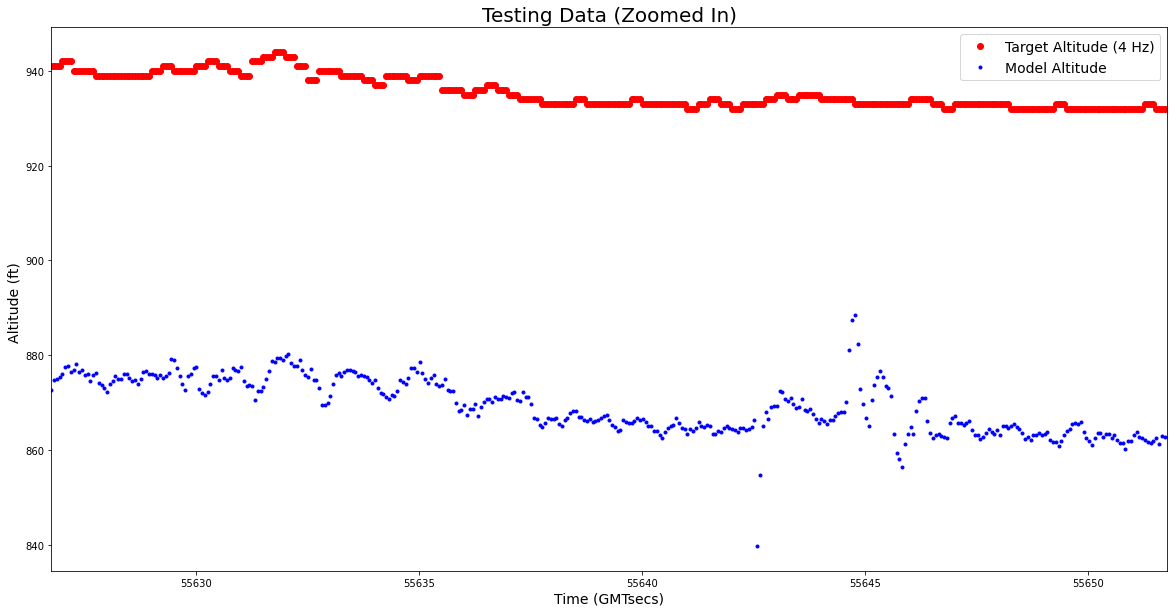

In [221]:
fig = plt.figure(figsize=(20,10))
#subplot 2
istart = 100
istop  = 500

#ax2 = plt.subplot(nv,1,2)
ax2 = plt.gca()
ax2.set_title('Testing Data (Zoomed In)', fontsize=20)
plt.plot(Timetest[istart:istop], Ttest_alt[istart:istop], 'ro', label='Target Altitude (4 Hz)')
plt.plot(Timetest[istart:istop], Ytest_alt[istart:istop], 'b.', label='Model Altitude')
plt.legend(fontsize=14)
plt.ylabel('Altitude (ft) ',fontsize=14)

plt.xlabel('Time (GMTsecs)',fontsize=14);
#plt.xticks(ticks=Timetest[istart:istop:10])
plt.xlim(Timetest[istart],Timetest[istop])
plt.show();

## Statistics about this average model answer

### Mean Squared Error

In [205]:
real_mse = scaleT.inverse_transform(avg_filter20.reshape(-1,1))[0,0] #inverse transform expects 2D array

print(f'The scaled MSE: {scaled_mse}\n')
print(f'The real MSE in units of Feet: {real_mse}')

The scaled MSE: 4.3755979277193546e-05

The real MSE in units of Feet: -245.80994734406775


### Standard Deviation

In [239]:
#values in real units (feet)

diff_alt = Ttest_alt - Ytest_alt
diff_alt.mean(), diff_alt.max(), min(abs(diff_alt))[0], diff_alt.std()


(54.19455754759832, 10840.084106445312, 0.0, 53.46788544968824)

In [161]:
model.n_layers

1